In [3]:
import os
import sys
thread = 8
os.environ["OMP_NUM_THREADS"] = str(thread) # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = str(thread) # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = str(thread) # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread) # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = str(thread) # export NUMEXPR_NUM_THREADS=6
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import time
#import pandas as pd
import numpy as np
import qml
from qml.math import cho_solve
from qml.kernels import gaussian_kernel
from qml.kernels import laplacian_kernel


In [4]:
X = np.load("./data/X.npy")
y = np.loadtxt("./data/E_def2-tzvp.dat")

In [5]:
class KRR_benchmark():
    def __init__(self, avg_mae, avg_training_time_cpu, avg_testing_time_cpu, 
                 avg_training_time_wall, avg_testing_time_wall, library, kernel, 
                 sample_size, sigma, alpha, seed = 42):
        self.avg_mae = avg_mae
        self.avg_training_time_cpu = avg_training_time_cpu
        self.avg_testing_time_cpu = avg_testing_time_cpu
        self.avg_training_time_wall = avg_training_time_wall
        self.avg_testing_time_wall = avg_testing_time_wall
        self.library = library
        self.kernel = kernel
        self.sample_size = sample_size
        self.sigma = sigma
        self.alpha = alpha
        self.seed = seed

In [6]:
class KRR():
    def __init__(self, alpha=1e-8, library = "qml", sigma = 720, kernel='gaussian', seed = 42):
        self.alpha = alpha
        self.sigma = sigma
        self.kernel = kernel
        self.library = library
        self.is_fit = False
        self.avg_mae = 0
        self.avg_training_time_cpu = 0
        self.avg_testing_time_cpu = 0
        self.avg_training_time_wall = 0
        self.avg_testing_time_wall = 0
        self.seed = seed

    def fit(self, X, y):
        np.random.seed(self.seed)
        self.X_ = X
        self.y_ = y
        start_cpu = time.process_time()
        start_wall = time.perf_counter()
        if self.library == "qml":
            if self.kernel == 'gaussian':
                K = gaussian_kernel(X, X, self.sigma)    
            elif self.kernel == 'laplacian':
                K = laplacian_kernel(X, X, self.sigma)
            K[np.diag_indices_from(K)] += self.alpha 
            self.beta = cho_solve(K, y)
        elif self.library == "scikit-learn":
            if self.kernel == 'gaussian':
                self.krr = KernelRidge(kernel = "rbf", gamma = 1/(2*self.sigma**2) , alpha=self.alpha)
            elif self.kernel == 'laplacian':
                self.krr = KernelRidge(kernel = "laplacian", gamma = 1/self.sigma, alpha=self.alpha)
            self.krr.fit(X, y)
        else:
            print("Error library")
        end_cpu = time.process_time()
        end_wall = time.perf_counter()
        self.training_time_wall = end_wall - start_wall
        self.training_time_cpu = end_cpu - start_cpu
        
        self.is_fit = True


    def predict(self, X):
        if not self.is_fit:
            print("Fit model first")
        start_cpu = time.process_time()
        start_wall = time.perf_counter()
        if self.library == "qml":
            if self.kernel == 'gaussian':
                Ks = gaussian_kernel(X, self.X_, self.sigma)  
            elif self.kernel == 'laplacian':
                Ks = laplacian_kernel(X, self.X_, self.sigma)
            y_predicted = np.dot(Ks, self.beta)
        elif self.library == "scikit-learn":
             y_predicted = self.krr.predict(X)
        end_cpu = time.process_time()
        end_wall = time.perf_counter()

        self.cpu_time = end_cpu - start_cpu
        self.testing_time_wall = end_wall - start_wall
        self.testing_time_cpu = end_cpu - start_cpu
        
        return y_predicted
    
    def compute_mae(self, X, y):
        y_predicted = self.predict(X)
        self.mae = np.mean(np.abs(y_predicted - y))
        return self.mae



In [167]:
sigma = 200
alpha = 1e-6

krr_array = np.empty((13, 2, 2), dtype=object) 
for l, kernel in enumerate(["laplacian", "gaussian"]):
    for k, lib in enumerate(["qml", "scikit-learn"]):
        mae_array = np.zeros((13,))
        training_wall_array = np.zeros((13,))
        testing_wall_array = np.zeros((13,))
        training_cpu_array = np.zeros((13,))
        testing_cpu_array = np.zeros((13,))
        for j in range(1, 11):
            for i in range(20):
                N = pow(2, i+1)
                if N > 10000:
                    break
                X_copy = X.copy()
                y_copy = y.copy()
                np.random.seed(j)
                np.random.shuffle(X_copy)
                np.random.seed(j)
                np.random.shuffle(y_copy)
                X_train = X_copy[:N]
                y_train = y_copy[:N]
                avg_mae = 0
                X_test = X_copy[9000:]#Taking remaining 1000 samples
                y_test = y_copy[9000:]
                krr_ins = KRR(alpha=alpha, library = lib, sigma = sigma, kernel=kernel, seed = j)
                krr_ins.fit(X_train, y_train)
                training_wall_array[i] += krr_ins.training_time_wall
                training_cpu_array[i] += krr_ins.training_time_cpu
                
                #Strictly for evaluation time comparisions. Bad for MAE calculations as training data is used for testing
                X_test_time = X_copy[:N] 
                krr_ins.predict(X_test_time)
                testing_wall_array[i] += krr_ins.testing_time_wall
                testing_cpu_array[i] += krr_ins.testing_time_cpu
                
                krr_ins.compute_mae(X_test, y_test)
                mae_array[i] += krr_ins.mae

                if j == 10:
                    krr_array[i, k, l] = KRR_benchmark(avg_mae = mae_array[i] /10,
                                                       avg_training_time_wall = training_wall_array[i] /10, 
                                                       avg_testing_time_wall = testing_wall_array[i] /10,
                                                       avg_training_time_cpu = training_cpu_array[i] /10,
                                                       avg_testing_time_cpu = testing_cpu_array[i] /10,
                                                       library = lib,
                                                       kernel = kernel,
                                                       sample_size = N,
                                                       sigma = sigma,
                                                       alpha = alpha,
                                                       seed = seed)


KeyboardInterrupt: 

In [10]:
# outfile = "/home/ssunar/Thesis/data/output_data_new/KRR_thread_" + str(thread) + ".npy"
# np.save(outfile, krr_array)

In [24]:
threads = [i for i in range(1, 21)]
krr_array = np.array([np.load("/home/ssunar/Thesis/data/output_data_new/KRR_thread_" + str(thread) + ".npy", allow_pickle=True) for thread in threads])

In [28]:
krr_array[0, 12, 0,0].avg_mae

0.0013727932717635526

In [15]:
def array_to_latex(arr):
    """
    Converts a 2D array into a LaTeX tabular environment with scientific notation and vertical/horizontal lines
    :param arr: 2D array to convert
    :return: LaTeX code as a string
    """
    rows = []
    for row in arr:
        rows.append(" & ".join("{:.2e}".format(val) if isinstance(val, (int, float)) else str(val) for val in row) + r" \\\hline")
    latex = r"\begin{tabular}{|" + "c|" * len(arr[0]) + "}\n"
    latex += "\hline \n"
    latex += "\n".join(rows)
    latex += "\n\end{tabular}"
    return latex

In [16]:
a = np.empty((2, 2))
for i in range(2):
    for j in range(2):
        a[i,j] = krr_array[0, 12, i, j].avg_mae
print(array_to_latex(a))

\begin{tabular}{|c|c|}
\hline 
1.37e-03 & 7.05e-03 \\\hline
1.37e-03 & 7.05e-03 \\\hline
\end{tabular}


In [13]:
def plot_avg_mae(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["qml", "scikit-learn"]
    for k, kernel_name in enumerate(kernel_names):
        for l, library_name in enumerate(library_names):
            if l == 0:
                ls = "-"
                alpha = 1
            else:
                alpha = 1
                ls = "--"
            avg_mae_array = np.zeros((13,))
            for i in range(13):
                avg_mae_array[i] = krr_array[0, i, l, k].avg_mae
            axs.loglog(np.array([2 ** i for i in range(1, 14)]), avg_mae_array, label=library_name+"_"+kernel_name, alpha = 0.7, linestyle = ls, linewidth = 2)
            axs.set_title(f"Learning curve KRR")
            axs.set_xlabel("Sample Size")
            axs.set_ylabel("Average MAE")
            axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Learning_curve_KRR.png", dpi = 200)

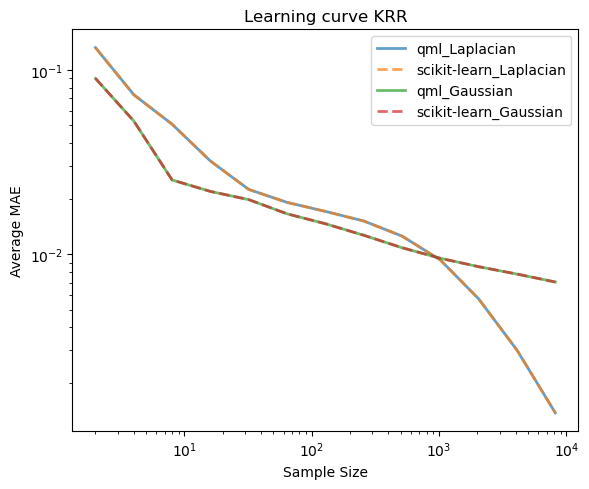

In [14]:
plot_avg_mae(krr_array)

In [17]:
def plot_avg_training(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["qml", "scikit-learn"]
    times_names = ["cpu_time", "wall_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time = np.zeros((13,))
                    for i in range(13):
                        if t  == 1:
                            avg_training_time[i] = krr_array[j, i, l, k].avg_training_time_wall
                        else:
                            avg_training_time[i] = krr_array[j, i, l, k].avg_training_time_cpu
                    axs[t].plot(np.array([2 ** i for i in range(1, 14)]), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[t].set_title(f"Training time plot KRR, Thread(s) = {thread}, Time={time_name}")
                    axs[t].set_xlabel("Sample Size")
                    axs[t].set_ylabel(f"Time in seconds")
                    axs[t].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Training_time_KRR.png", dpi = 200)

In [20]:
def plot_avg_testing(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["qml", "scikit-learn"]
    times_names = ["cpu_time", "wall_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_testing_time = np.zeros((13,))
                    for i in range(13):
                        if t  == 1:
                            avg_testing_time[i] = krr_array[j, i, l, k].avg_testing_time_wall
                        else:
                            avg_testing_time[i] = krr_array[j, i, l, k].avg_testing_time_cpu
                    axs[t].plot(np.array([2 ** i for i in range(1, 14)]), avg_testing_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[t].set_title(f"Evaluation time plot KRR, Thread(s) = {thread}, Time = {time_name}")
                    axs[t].set_xlabel("Sample Size")
                    axs[t].set_ylabel(f"Time in seconds")
                    axs[t].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Evaluation_time_KRR.png", dpi = 200)

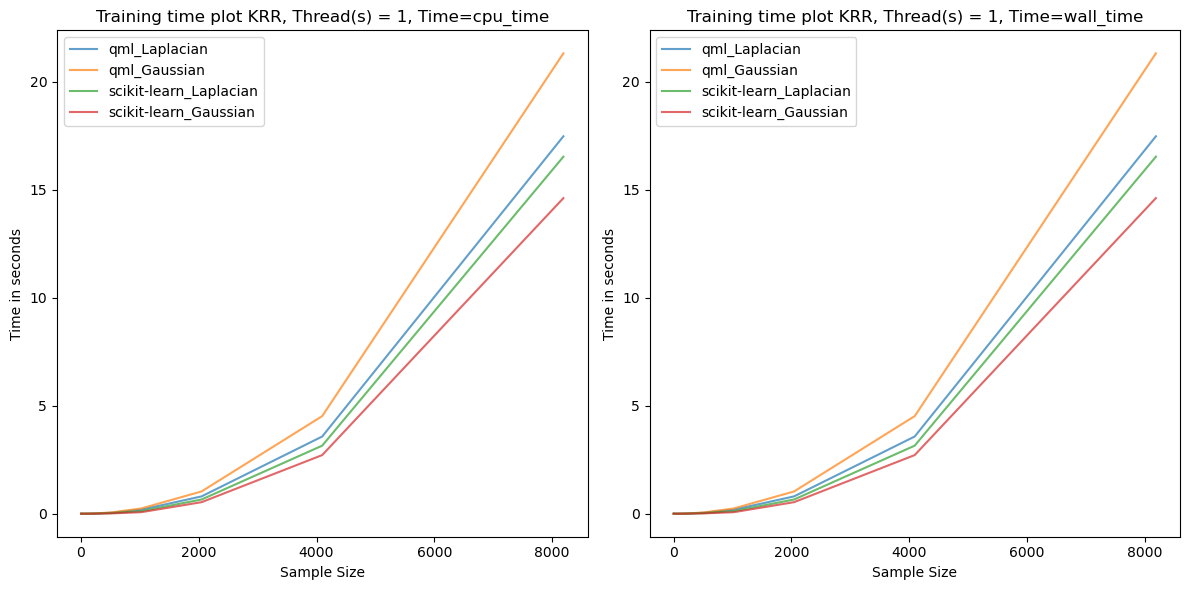

In [18]:
plot_avg_training(krr_array)

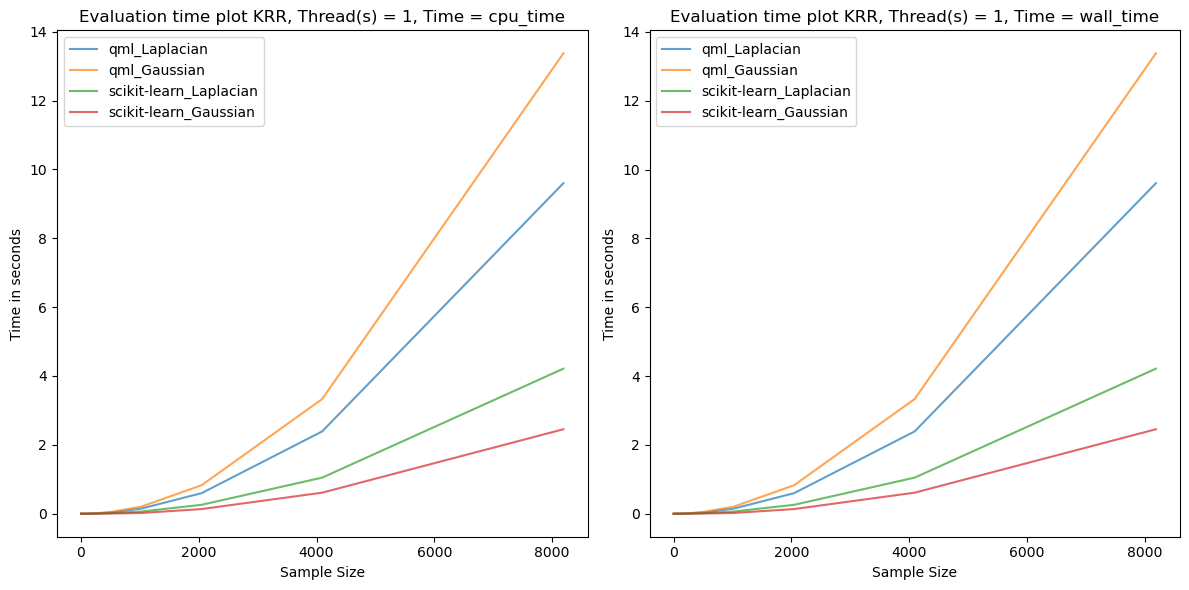

In [21]:
plot_avg_testing(krr_array)

In [25]:
def plot_scalability(krr_array):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["qml", "scikit-learn"]
    times_names = ["wall_time", "cpu_time"]
    threads = [i for i in range(1, 21)]
    samples_idx = [9, 11, 12]
    

    for i, sample_idx in enumerate(samples_idx):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time= np.zeros((20,))
                    for j, thread in enumerate(threads):
                        if time_name == "wall_time":
                            avg_training_time[j-1] = krr_array[j-1, sample_idx, l, k].avg_training_time_wall
                        else:
                            avg_training_time[j-1] = krr_array[j-1, sample_idx, l, k].avg_training_time_cpu
                    axs[i][t].plot(np.array(threads), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[i][t].set_title(f"Training time Scalability plot KRR, Samples={2**(sample_idx+1)}, Time={time_name}")
                    axs[i][t].set_xlabel("Number of threads")
                    axs[i][t].set_ylabel(f"times in seconds")
                    axs[i][t].set_xticks([i for i in range(1, 21)])
                    axs[i][t].legend(handletextpad=0.1)
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Scalability_Training_time.png", dpi = 200)

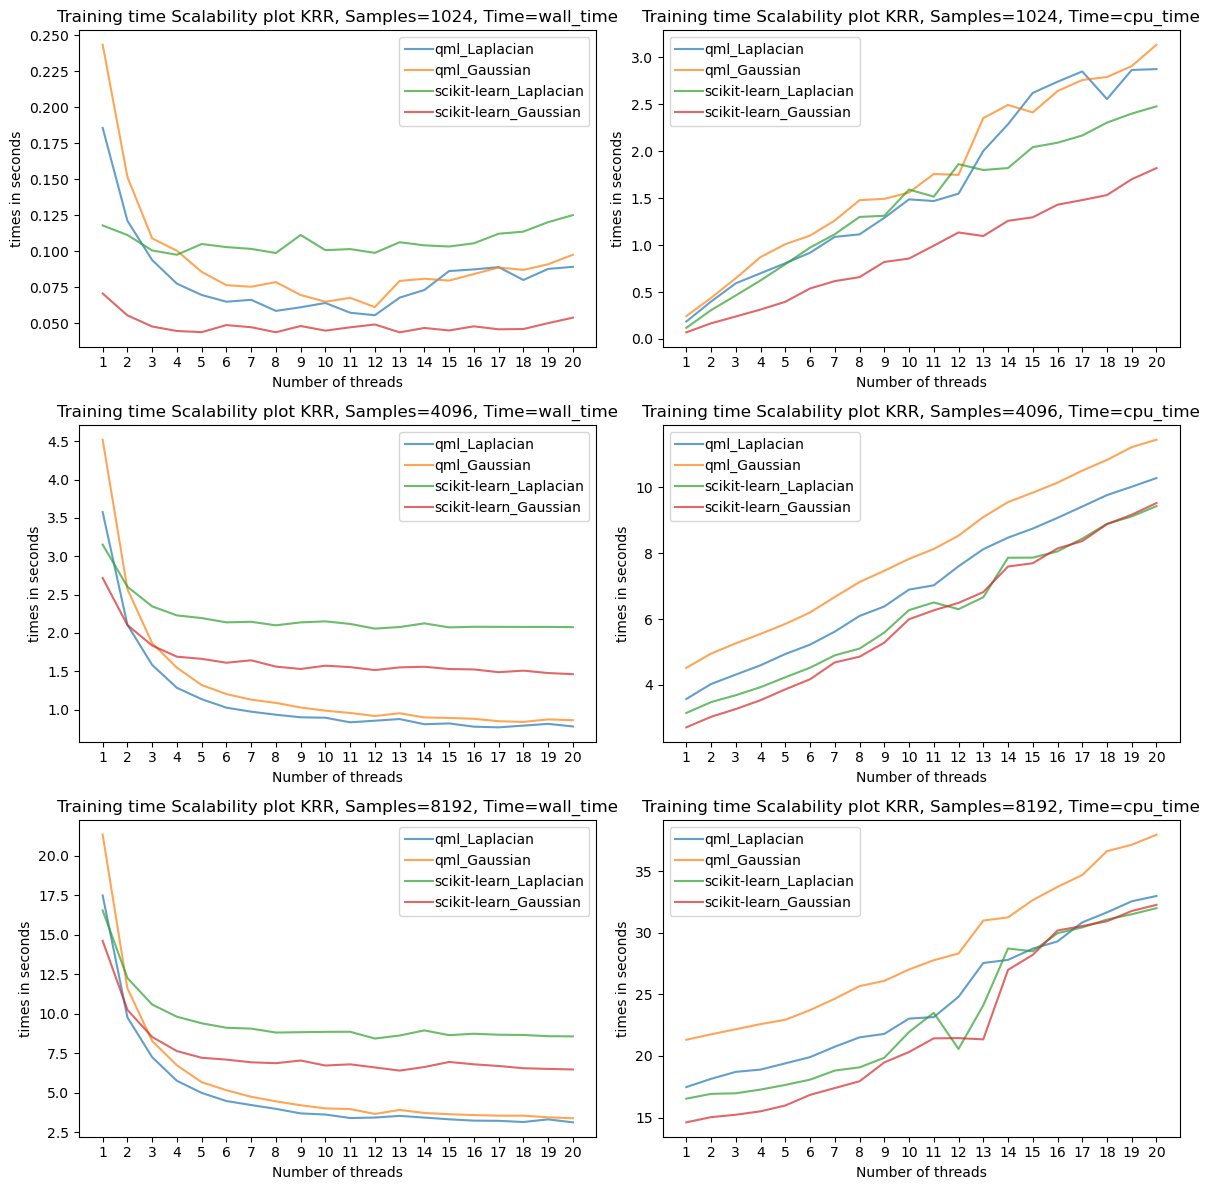

In [26]:
plot_scalability(krr_array)